# 1. LSTM

## 1)  데이터 준비 및 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 네이버 댓글 불러오기
#train, test data로 구분
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
print(train_data.head)


<bound method NDFrame.head of               id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[150000 rows x 3 columns]>


## 2) 사용함수 정의

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab() # 형태소 분석기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복처리
    train_data = train_data.dropna(how = 'any') # 결측치 처리
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist() # 행렬로 만들어주는 페이지
    counter = Counter(words) # 행렬수 카운트
    counter = counter.most_common(10000-4) # 지정된 단어는 제거
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # 하나씩 저장
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist): # 없으면 
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))#위 함수를 하나씩 불러와서 list로 저장
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공


* ### 데이터셋 내 문장 길이 분포

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


* ### 적절한 최대 문장 길이 지정
  * 최대 길이를 표준편차의 1배로 설정하면 문장이 포함되지 않았고, 3배로 설정하면 97%가 포함되지만 성능이 좋지 않았습니다.

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.981694052619337


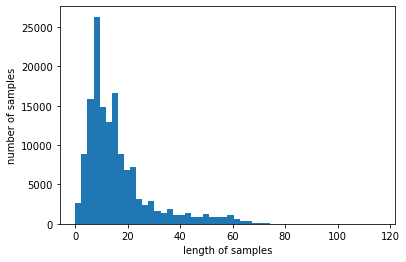

In [7]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* ### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
  * pre가 post에 비해 약 10% 이상의 성능 차이를 보인다고 합니다.

In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(len(word_to_index))
vocab_size = len(word_to_index)    # 어휘 사전 크기
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,  )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

10000
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [89]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

## 5) 모델 훈련 개시

### 모델분리

In [90]:
# validation set 20,000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 학습
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 모델훈련

In [91]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=216,
                    validation_data=(x_val, y_val),
                    verbose=1)
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/4
585/585 [==============================] - 4s 6ms/step - loss: 0.4381 - accuracy: 0.7912 - val_loss: 0.3456 - val_accuracy: 0.8511
Epoch 2/4
585/585 [==============================] - 3s 5ms/step - loss: 0.3243 - accuracy: 0.8619 - val_loss: 0.3355 - val_accuracy: 0.8544
Epoch 3/4
585/585 [==============================] - 3s 5ms/step - loss: 0.2997 - accuracy: 0.8729 - val_loss: 0.3354 - val_accuracy: 0.8529
Epoch 4/4
585/585 [==============================] - 3s 5ms/step - loss: 0.2797 - accuracy: 0.8820 - val_loss: 0.3369 - val_accuracy: 0.8540


### 데이터 평가(test data)

In [92]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3465 - accuracy: 0.8507
[0.3464806377887726, 0.8506824970245361]


# 6) Loss, Accuracy 그래프 시각화

In [93]:
history_dict = history.history#시각화를 위해 dic화
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


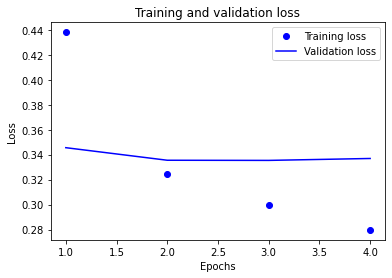

In [94]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

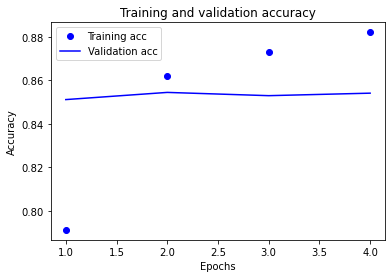

In [95]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [96]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [97]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')# 텍스트 파일 만들어주기(write)
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [98]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([-0.01937122, -0.05964056, -0.07362086,  0.08559328,  0.03157284,
       -0.01568213, -0.06100777,  0.02156188, -0.02947221,  0.01368251,
       -0.04859229,  0.05677914, -0.16734943, -0.0561224 , -0.00776098,
       -0.0555508 ], dtype=float32)

In [99]:
word_vectors.similar_by_word("강아지")

[('공부', 0.9413213729858398),
 ('과도', 0.9265956878662109),
 ('트와일라잇', 0.9243767857551575),
 ('맘대로', 0.9225387573242188),
 ('헤', 0.9221959114074707),
 ('삼가', 0.9212942123413086),
 ('트리', 0.9096278548240662),
 ('잊혀질', 0.9066463112831116),
 ('꺅', 0.9064929485321045),
 ('닷', 0.9031543731689453)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [100]:
#from gensim.models import KeyedVectors
# word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['사랑']
# vector     # 무려 300dim의 워드 벡터입니다.

In [101]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
a = ko_model.wv.most_similar("강아지")
vector = ko_model['강아지']
print(a)
#print(vector)
len(vector)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


200

In [102]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (학습된 데이터의 정해진 차원에 맞춰줌, 하이퍼파라미터 아님)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]] # embedding - 메트릭스 틀을 만들어줌

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [103]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [104]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 6s 26ms/step - loss: 0.5587 - accuracy: 0.6975 - val_loss: 0.4441 - val_accuracy: 0.7945
Epoch 2/4
247/247 [==============================] - 6s 26ms/step - loss: 0.3912 - accuracy: 0.8259 - val_loss: 0.3781 - val_accuracy: 0.8310
Epoch 3/4
247/247 [==============================] - 6s 26ms/step - loss: 0.3316 - accuracy: 0.8587 - val_loss: 0.3594 - val_accuracy: 0.8430
Epoch 4/4
247/247 [==============================] - 6s 26ms/step - loss: 0.2951 - accuracy: 0.8771 - val_loss: 0.3567 - val_accuracy: 0.8489


In [105]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3677 - accuracy: 0.8442
[0.3677215576171875, 0.8442134261131287]


# 2. 1-D Convolution Neural Network(1-D CNN)

In [106]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

# 5) 모델 훈련 개시

### 모델분리(train : validation = 9 : 1)

In [107]:
# validation set 14000건 분리
x_val = X_train[:14000]   
y_val = y_train[:14000]

# validation set을 제외한 나머지
partial_x_train = X_train[14000:]  
partial_y_train = y_train[14000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(132182, 41)
(132182,)


### 모델훈련

In [108]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
259/259 [==============================] - 1s 5ms/step - loss: 0.5120 - accuracy: 0.7376 - val_loss: 0.3517 - val_accuracy: 0.8449
Epoch 2/4
259/259 [==============================] - 1s 5ms/step - loss: 0.3255 - accuracy: 0.8614 - val_loss: 0.3394 - val_accuracy: 0.8538
Epoch 3/4
259/259 [==============================] - 1s 5ms/step - loss: 0.2908 - accuracy: 0.8788 - val_loss: 0.3334 - val_accuracy: 0.8570
Epoch 4/4
259/259 [==============================] - 1s 5ms/step - loss: 0.2624 - accuracy: 0.8922 - val_loss: 0.3368 - val_accuracy: 0.8588


### 데이터 평가(test data)

In [109]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3517 - accuracy: 0.8516
[0.3517189919948578, 0.8516182899475098]


# 6) Loss, Accuracy 그래프 시각화

In [110]:
history_dict = history.history#시각화를 위해 dic화
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


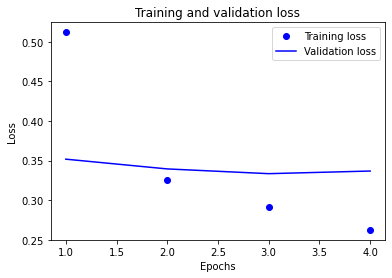

In [111]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

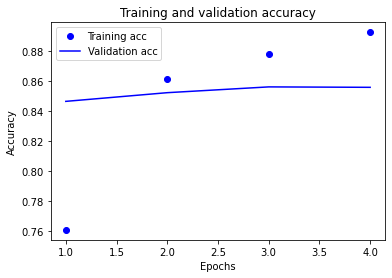

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')# 텍스트 파일 만들어주기(write)
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([ 0.04013646,  0.02908405, -0.05487929,  0.01623219,  0.02016216,
       -0.01000496,  0.03723833,  0.01669479,  0.06539505,  0.04649538,
        0.01150243, -0.03249888,  0.06364097, -0.00080269,  0.05146126,
        0.00083746], dtype=float32)

In [37]:
word_vectors.similar_by_word("강아지")

[('맙시다', 0.8276097774505615),
 ('추억', 0.7971535325050354),
 ('kbs', 0.787441074848175),
 ('웨이', 0.7525984048843384),
 ('아닌가', 0.7355023622512817),
 ('도입부', 0.7282721996307373),
 ('다를', 0.7266619205474854),
 ('조명', 0.717138409614563),
 ('완성도', 0.7157626152038574),
 ('스콧', 0.7142369747161865)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [38]:
#from gensim.models import KeyedVectors
# word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['사랑']
# vector     # 무려 300dim의 워드 벡터입니다.

In [39]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
a = ko_model.wv.most_similar("강아지")
vector = ko_model['강아지']
print(a)
#print(vector)
len(vector)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


200

In [40]:
# embedding - 메트릭스 틀을 만들어줌

In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (정해진 차원에 맞춰줌, 하이퍼 파라미터 아님)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [43]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
259/259 [==============================] - 11s 43ms/step - loss: 0.5603 - accuracy: 0.6950 - val_loss: 0.4371 - val_accuracy: 0.8006
Epoch 2/4
259/259 [==============================] - 6s 24ms/step - loss: 0.3862 - accuracy: 0.8292 - val_loss: 0.3696 - val_accuracy: 0.8371
Epoch 3/4
259/259 [==============================] - 6s 24ms/step - loss: 0.3275 - accuracy: 0.8604 - val_loss: 0.3599 - val_accuracy: 0.8426
Epoch 4/4
259/259 [==============================] - 6s 24ms/step - loss: 0.2943 - accuracy: 0.8771 - val_loss: 0.3481 - val_accuracy: 0.8488


In [44]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3632 - accuracy: 0.8429
[0.3632066249847412, 0.8429114818572998]


# 3. GlobalMaxPooling1D

In [157]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 256   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 256)         2560000   
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 2,564,129
Trainable params: 2,564,129
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시

### 모델분리(train : validation = 9 : 1)

In [186]:
# validation set 20,000건 분리
x_val = X_train[:14000]   
y_val = y_train[:14000]

# validation set을 제외한 나머지
partial_x_train = X_train[14000:]  
partial_y_train = y_train[14000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(132182, 41)
(132182,)


### 모델훈련

In [187]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
517/517 [==============================] - 11s 22ms/step - loss: 0.2437 - accuracy: 0.9015 - val_loss: 0.3547 - val_accuracy: 0.8513
Epoch 2/4
517/517 [==============================] - 11s 22ms/step - loss: 0.2210 - accuracy: 0.9124 - val_loss: 0.3555 - val_accuracy: 0.8524
Epoch 3/4
517/517 [==============================] - 11s 22ms/step - loss: 0.1982 - accuracy: 0.9237 - val_loss: 0.3764 - val_accuracy: 0.8477
Epoch 4/4
517/517 [==============================] - 11s 22ms/step - loss: 0.1766 - accuracy: 0.9338 - val_loss: 0.4044 - val_accuracy: 0.8467


### 데이터 평가(test data)

In [188]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4312 - accuracy: 0.8406
[0.43122467398643494, 0.8405720591545105]


# 6) Loss, Accuracy 그래프 시각화

In [189]:
history_dict = history.history # 시각화를 위해 dic화
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


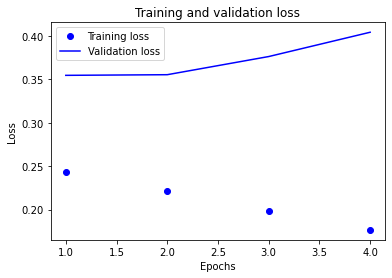

In [190]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

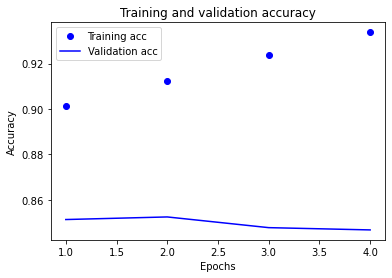

In [191]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [212]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [213]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')# 텍스트 파일 만들어주기(write)
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [217]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [218]:
word_vectors.similar_by_word("강아지")

[('고양이', 0.7348839044570923),
 ('토끼', 0.701525092124939),
 ('엄마', 0.6917544603347778),
 ('아빠', 0.663833498954773),
 ('아가씨', 0.6518468260765076),
 ('돼지', 0.621900200843811),
 ('거북이', 0.6128400564193726),
 ('뱀파이어', 0.6096034049987793),
 ('아저씨', 0.6068869829177856),
 ('개구리', 0.6061614751815796)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [204]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
a = ko_model.wv.most_similar("강아지")
vector = ko_model['강아지']
print(a)
#print(vector)
len(vector)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


200

In [205]:
# embedding - 메트릭스 틀을 만들어줌

In [206]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (정해진 차원에 맞춰줌, 하이퍼 파라미터 아님)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [207]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 16)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

In [208]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=216,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
612/612 [==============================] - 13s 22ms/step - loss: 0.4827 - accuracy: 0.7612 - val_loss: 0.3875 - val_accuracy: 0.8253
Epoch 2/4
612/612 [==============================] - 13s 21ms/step - loss: 0.3468 - accuracy: 0.8501 - val_loss: 0.3512 - val_accuracy: 0.8457
Epoch 3/4
612/612 [==============================] - 13s 21ms/step - loss: 0.3017 - accuracy: 0.8736 - val_loss: 0.3356 - val_accuracy: 0.8526
Epoch 4/4
612/612 [==============================] - 13s 22ms/step - loss: 0.2716 - accuracy: 0.8887 - val_loss: 0.3414 - val_accuracy: 0.8516


In [209]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3548 - accuracy: 0.8506
[0.35481446981430054, 0.8505808115005493]


# 루브릭

* ## 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
  * LSTM, 1-D CNN, GlobalMaxPooling1D 세 가지 방법을 활용했습니다.
  * 모델의 성능을 올리기 위한 몇가지 하이퍼파라미터를 변경해보았습니다.
    * 워드 벡터의 차원수를 조정했습니다. 워드 백터의 차원 수는 해당 단어를 판단하는 기준으로 단어를 어느 정도의 수준으로 쪼개어 볼 것인지에 대한 하이퍼 파라미터라고 생각합니다. 기존 16에서 300으로 증가 시, 에포크당 소요 시간은 3초에서 17초로 약 6배 증가하였지만 동일한 조건 하에서 성능은 약 1%낮은 83%대로 나타났습니다. 반면 차원 수 감소 시(16 -> 8회), 감소의 폭은 줄었지만 마찬가지로 84.76%에서 84.56%로 감소했습니다. 따라서 단어의 차원 수는 16으로 고정했습니다. 
    * train set과 validation set의 비율을 지속적으로 조정했습니다. 데이터에 따라, 그리고 연구자에 따라 다르겠지만 9:1비율의 k-validatoin을 생각했습니다. 따라서 9:1비율(validation 14,000)로 설정하고 진행했지만 성능이 85%를 넘지 못해, 20,000으로 진행 한 결과가 더 잘 나왔습니다.근소한 차이였기 때문에 무엇이 낫다 판단하긴 어려웠습니다. 하지만 validation set의 비율이 과하게 높아지면 성능이 감소했습니다. 이는 충분한 학습이 이루어지지 못하기 때문으로 보입니다.
    * batch size를 조정했습니다. 최적 loss값을 찾아 나갈때, 모든 요소별 loss계산은 매우 비효율적입니다. 따라서 일정 양의 '표본'을 뽑아서 loss값을 계산해 나가는데, 이것이 batch입니다. 이 batch의 사이즈를 적절히 조절해주면 모델의 성능과 속도를 향상시킬 수 있습니다. 노드에서 주어잔 512회보다 216회로 변경하였을 때 성능이 더 좋게 나타났습니다.
    * 가장 빈번하게 조정한 것은 epoch였습니다. epoch는 학습을 시키는 횟수를 결정하는 하이퍼파라미터로써, 몇회를 훈련시키느냐에 따라 과적합이 일어날 수도, 적절한 훈련이 일어날 수도 있는 중요한 하이퍼파라미터입니다. 이는 그래프를 그려 판단해볼 수 있었습니다. 10회를 기준으로, 1회에서 진행될수록 train set의 loss값은 감소한 반면, validation set의 loss값은 증가하였습니다. 이에 validation loss가 급격히 증가하기 직전인 epoch 4를 기준으로 1회, 2회, 3회, 4회를 후보로 두었습니다. accuracy의 경우, 2회에서 train set과 validation set의 간격이 가장 좁았으나 4회까지 큰 차이를 보이지 않았습니다. 따라서 2회, 4회를 최종 후보로 검증하였습니다. 그 결과 4회 학습의 성능이 더 좋게 나왔습니다.

* ## 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
   * 이미 구축된 사전을 활용햐여 사전학습 임베딩 레이어를 분석
     * 우리가 보유한 데이터와 모델로 학습시킨 워드벡터파일을 활용해 강아지와 유사한 단어를 추출했습니다. 첫번째 모델의 경우 '공부', '트와일라잇' 등을 유사한 유형의 단어로 보았고, 두번째 모델은 '추억', 'kbs' 등을, 세번쨰 모델은 앞선 두 모델에 비해 상당수준 유사한 '고양이', '토끼', '엄마', '아빠'등을 유사한 단어라고 판단했습니다. 그러나 사전에 학습된 Word2Vec 워드 임베딩 모델을 활용하니 유사한 단어로 '고양이', '멧돼지', '토끼' 등 우리의 모델과 데이터로 평가한 모델에 비해 훨씬 유사한 단어를 추출한걸 확인할 수 있습니다.

* ## 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
    * 여러가지 시도를 하였으나, 결과적으로 위의 두 모델은 기존 수치 비해 약간씩 떨어진 성능을 보였습니다. 위에서 우리가 학습시킨 사전에 비해 훨씬 상식적인 결과물을 추출하는 건 확인하였기 때문에 제대로 동작한다면 더 나은 성능을 보일 것이 분명했기에 하이퍼파라미터를 조절해가며 여러 시도를 했지만, 결국 원 모델에 비해 성능을 높이는데 실패했습니다. 그러나 마지막 모델은 Word2Vec 사용으로 accuracy가 84%에서 85%로 향상되었습니다.

# 느낀점
* 모델을 구성하는데 하이퍼파라미터를 어떻게 구성하는지가 중요하다는 것을 알 수 있었습니다. 또 같은 모델이라도 설정하는 하이퍼 파라미터에 따라, 그리고 데이터의 수와 특성에 따라서도 많은 기준이 바뀌게 된다는 것을 알 수 있었습니다. 지금은 단순 무식하게 노가다를 할 수 밖에 없지만 언젠가 기준을 갖고 판단을 하여 조절할 수 있게 되길 바랍니다.
* NLP라는 분야는 굉장히 매력적입니다. 익명의 가면 뒤에서 자신의 내면의 목소리를 낼 수 있는 공간, 그 속에서 나온 사람의 진심을 분석하고 이를 통해 얻은 인사이트를 여러 분야에 접목할 수 있습니다. 이런 분야에 대해 이론적으로, 그리고 기술적으로도 많은 내용을 새로 알게 된 노드였습니다.